# STATS 231A Homework 5 - Candace McKeag

VAE, tSNE, and Spectral Embedding and Clustering.

# Env Setup

In [3]:
from abc import ABC
from IPython import display
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import tensorflow_docs.vis.embed as embed
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
import seaborn as sns

sns.set(rc={'figure.figsize': (11.7, 8.27)})
palette = sns.color_palette("bright", 10)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# !pip install -q tensorflow-probability
# !pip install -q imageio
# !pip install -q git+https://github.com/tensorflow/docs

# Problem 1 - VAE

Study and play with the following code for VAE.

https://www.tensorflow.org/tutorials/generative/cvae

In [6]:
# define the encoder and decoder networks
class CVAE(tf.keras.Model, ABC):
    """
    Builds the Convolutional Variational Autoencoder. Uses tf.keras.Sequential to define the encoder and decoder
     networks. Each network is a small ConvNet.
    """
    def __init__(self, latent_dim):
        """
        Constructs necessary parameters for CVAE.
        :param latent_dim: dimension of latent sample
        """
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        # encoder takes an observation as input and outputs a set of parameters for specifying the conditional
        # distribution of the latent representation
        # architecture: two convolutional layers followed by a fully-connected layer
        # defines approx posterior distr p(z|x)
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(self.latent_dim + self.latent_dim),
            ]
        )
        # decoder takes a latent sample as input and outputs the parameters for a conditional distribution of
        # the observation
        # architecture: fully-connected layer followed by three convolutional transpose layers
        # defines conditional distr p(x|z)
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(self.latent_dim,)),
                tf.keras.layers.Dense(units=7 * 7 * 32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        """
        Samples standard normal RVs and passes them through decoder
        :param eps: optional RV input
        :return: decoded sample
        """
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        """
        Passes input through encoder, splits into sub-tensors
        :param x: input to encode
        :return: mean, logvar
        """
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    @staticmethod
    def reparameterize(mean, logvar):
        """
        Generates normal RVs then scales them with inputted variance and shifts them with inputted mean.
        Approximates z using the decoder parameters and an epsilon.
        :param mean: shift
        :param logvar: scale
        :return: reparameterized vector
        """
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        """
        Passes input through decoder.
        :param z: input
        :param apply_sigmoid: bool, whether to apply sigmoid activation
        :return: logit probs
        """
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits


class VAE:
    """
    Trains a Variational Autoencoder on the MNIST dataset. The VAE maps the input data into the parameters of a
     probability distribution, such as the mean and variance of a Gaussian. This approach produces a continuous,
      structured latent space, which is useful for image generation.
    """
    def __init__(self, epochs=10, latent_dim=2, num_examples_to_generate=16, batch_size=32):
        """
        Constructs necessary parameters for VAE.
        :param epochs: num epochs to train
        :param latent_dim: dimension of latent sample
        :param num_examples_to_generate: num examples to generate
        :param batch_size: size of training batches
        """
        # define the optimizer
        # optimize the single sample MC estimate of the ELBO
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        # training
        self.epochs = epochs
        # set the dimensionality of the latent space to a plane for visualization later
        self.latent_dim = latent_dim
        self.num_examples_to_generate = num_examples_to_generate
        self.batch_size = batch_size

        # keeping the random vector constant for generation (prediction) so
        # it will be easier to see the improvement.
        self.random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, self.latent_dim])
        self.model = CVAE(self.latent_dim)

    def __call__(self):
        """
        Generates training and testing data, trains the network, displays a generated image from the last training
         epoch, then plots images decoded from the latent space.
        :return: nothing
        """
        self.train_dataset, self.test_dataset = self.get_data()
        self.train()
        # display a generated image from the last training epoch
        plt.imshow(self.display_image(self.epochs))
        plt.axis('off')

        # plots n x n digit images decoded from the latent space
        self.plot_latent_images(20)

    @staticmethod
    def preprocess_images(images):
        """
        Represent each pixel with a Bernoulli distribution and statically binarize the data.
        :param images: array of size 784 vectors
        :return: binarized image data
        """
        images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
        return np.where(images > .5, 1.0, 0.0).astype('float32')

    def get_data(self):
        """
        Loads the MNIST dataset. Each image is originally a vector of 784 integers, each between 0 and 255,
         representing the intensity of a pixel.
        :return: preprocessed train_dataset, test_dataset
        """
        # load the MNIST dataset
        (train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

        train_images = self.preprocess_images(train_images)
        test_images = self.preprocess_images(test_images)

        train_size = 60000
        batch_size = self.batch_size
        test_size = 10000

        # use tf.data to batch and shuffle data
        train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                         .shuffle(train_size).batch(batch_size))
        test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                        .shuffle(test_size).batch(batch_size))

        return train_dataset, test_dataset

    @staticmethod
    def log_normal_pdf(sample, mean, logvar, raxis=1):
        """
        Loss function
        :param sample: inputted sample
        :param mean: log normal mean
        :param logvar: lognorm variance to scale data
        :param raxis: axis to sum on
        :return: sum of elements of log normal pdf
        """
        log2pi = tf.math.log(2. * np.pi)
        return tf.reduce_sum(
            -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
            axis=raxis)

    def compute_loss(self, x):
        """
        Computes ELBO loss.
        :param x: input
        :return: Monte Carlo estimate of ELBO
        """
        mean, logvar = self.model.encode(x)
        z = self.model.reparameterize(mean, logvar)
        x_logit = self.model.decode(z)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = self.log_normal_pdf(z, 0., 0.)
        logqz_x = self.log_normal_pdf(z, mean, logvar)
        return -tf.reduce_mean(logpx_z + logpz - logqz_x)

    @tf.function
    def train_step(self, x):
        """
        Executes one training step and returns the loss. This function computes the loss and gradients,
        and uses the latter to update the model's parameters.
        :param x: training input
        :return: nothing
        """
        # compute loss
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        # compute gradients
        gradients = tape.gradient(loss, self.model.trainable_variables)
        # update model parameters
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    def generate_and_save_images(self, epoch, test_sample):
        """
        Samples a set of latent vectors from unit Gaussian prior which is then passed to the generator. The generator
         converts the latent sample to logits of the observation. The probabilities of the Bernoulli are then plotted.
        :param epoch: training epoch num
        :param test_sample: test sample
        :return: nothing
        """
        mean, logvar = self.model.encode(test_sample)
        # z is shape mean.shape
        z = self.model.reparameterize(mean, logvar)
        predictions = self.model.sample(z)
        fig = plt.figure(figsize=(4, 4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(predictions[i, :, :, 0], cmap='gray')
            plt.axis('off')

        # tight_layout minimizes the overlap between 2 sub-plots
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

    def train(self):
        """
        Performs all training steps, computing loss at each epoch.
        :return: nothing
        """
        # Pick a sample of the test set for generating output images
        assert self.batch_size >= self.num_examples_to_generate
        # iterate over the dataset
        for test_batch in self.test_dataset.take(1):
            test_sample = test_batch[0:self.num_examples_to_generate, :, :, :]
            self.generate_and_save_images(0, test_sample)

            for epoch in range(1, self.epochs + 1):
                print('Training Epoch {} ...'.format(epoch))
                # perform and time all training steps for dataset
                start_time = time.time()
                for train_x in self.train_dataset:
                    self.train_step(train_x)
                end_time = time.time()

                # compute loss on test
                loss = tf.keras.metrics.Mean()
                for test_x in self.test_dataset:
                    loss(self.compute_loss(test_x))
                elbo = -loss.result()
                display.clear_output(wait=False)
                print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
                      .format(epoch, elbo, end_time - start_time))
                self.generate_and_save_images(epoch, test_sample)

    @staticmethod
    def display_image(epoch_no):
        """
        Displays a generated image from the last training epoch.
        :param epoch_no: epoch number
        :return: generated image
        """
        return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

    def plot_latent_images(self, n, digit_size=28):
        """
        Displays a 2D manifold of digits from the latent space. Plots n x n digit images decoded from the latent space.
        :param n: size of images
        :param digit_size: (image width)/n
        :return: nothing
        """

        norm = tfp.distributions.Normal(0, 1)
        grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
        grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
        image_width = digit_size * n
        image_height = image_width
        image = np.zeros((image_height, image_width))

        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z = np.array([[xi, yi]])
                x_decoded = self.model.sample(z)
                digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
                image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

        plt.figure(figsize=(10, 10))
        plt.imshow(image, cmap='Greys_r')
        plt.axis('Off')
        plt.show()

Epoch: 10, Test set ELBO: -156.331787109375, time elapse for current epoch: 84.97646808624268


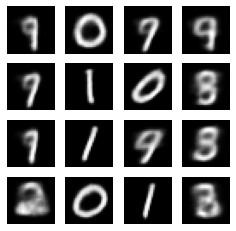

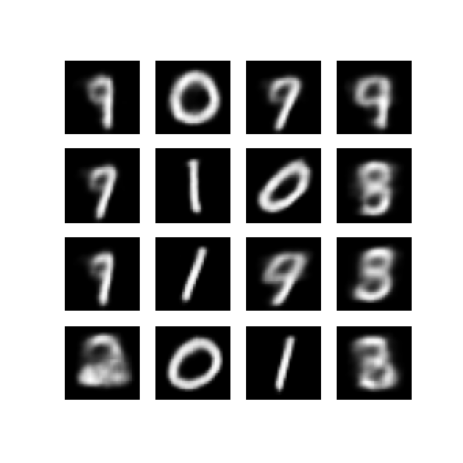

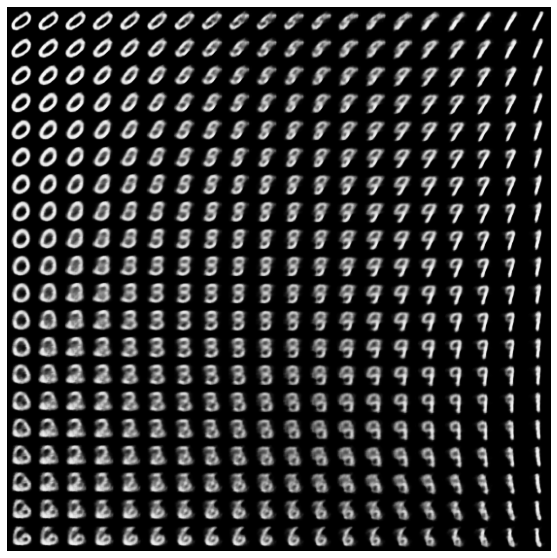

In [7]:
vae = VAE()
vae()

## (a) Brief Summary

Write a brief summary of the code. Annotate key lines.

*Each function/method has been annotated and described in the docstrings in the code above.*

This code trains a variational autoencoder on the MNIST dataset. A variational autoencoder uses a probability distribution to model observations in latent space. The encoder describes a probability distribution for each latent attribute. In our autoencoder, we model each pixel with a Bernoulli distribution. 

When we define our `VAE()` object, it first initializes parameters and methods such as the optimizer function, the latent space dimension, and the model itself, which is a `CVAE()` object. The `CVAE` class provides us with the actual convolutional variational autoencoder model. It consists of two small ConvNets, the encoder and decoder, and takes as input an observation and can output the parameters for a conditional distribution of the observation.

Once our model is initialized, we generate and preprocess the MNIST data, then use it to train the model. The training starts with picking a sample of the test set and generating output images for it. Then, during each epoch, we compute the ELBO loss and gradients and use the latter to update the model's parameters. Once training is finalized, we assess our progress by analyzing several images: a generated image from the last training epoch, an animated gif of all the saved images from every epoch, and digit images that have been decoded from the latent space.

## (b) Plot

Let the dimension of hidden vector be 2, plot the generated $g(z1, z2)$ for different $(z1, z2)$. You can arrange the generated images in the 2-dimensional space according to $(z1, z2)$.

We have that $z$ is the 2-dimensional latent vector. As part of training the variational autoencoder, we use the `generate_and_save_images()` function to sample a set of latent vectors from unit Gaussian prior and then pass them to the generator. The generator converts the latent sample to logits of the observation. The probabilities of the Bernoulli are then plotted. This plot of the probabilities is what we will show. We display an animated gif of all the generated images at each training epoch.

**PLEASE NOTE THAT IN THE PDF, THE FOLLOWING GIF WILL NOT DISPLAY CORRECTLY. TO SEE THE GIF OF THE GENERATED Z PROBABILITIES, PLEASE CHECK THE .IPYNB FILE.**


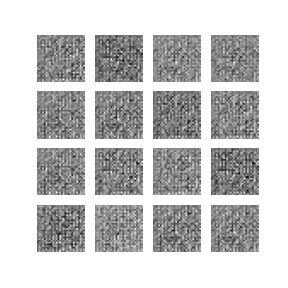

In [42]:
# display an animated gif of all the saved images
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

embed.embed_file(anim_file)

# Problem 2 - tSNE

Study and play with the following code for tSNE.

https://towardsdatascience.com/t-sne-python-example-1ded9953f26

In [43]:
class tSNE:
    """
    Performs t-Distributed Stochastic Neighbor Embedding dimensionality reduction. Represents high-dim data in a low-dim
     space so that it can be visualized. Creates a reduced feature space where similar samples are modeled by nearby
      points and dissimilar samples are modeled by distant points with high probability.
    """
    def __init__(self, n_components=2, perplexity=30):
        """
        Constructs necessary parameters for tSNE.
        :param n_components: num components to reduce data to
        :param perplexity: related to num of nearest neighbors used in tSNE algo
        """
        # work with hand-drawn digits
        self.X, self.y = load_digits(return_X_y=True)
        # smallest representable positive number s.t. 1 + epsilon != 1
        self.MACHINE_EPSILON = np.finfo(np.double).eps
        self.n_components = n_components
        self.perplexity = perplexity

    def __call__(self):
        """
        Fits tSNE transformation and plots clusters.
        :return: nothing
        """
        X_embedded = self.fit()
        sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=self.y, legend='full', palette=palette)

    def fit(self):
        """
        Performs tSNE transformation. Uses joint probability distribution to create reduced feature space.
        :return: tSNE transformed embedding
        """
        # store the number of samples
        n_samples = self.X.shape[0]

        # Compute euclidean distance btwn each data point
        distances = pairwise_distances(self.X, metric='euclidean', squared=True)

        # Compute joint probabilities p_ij from distances.
        P = _joint_probabilities(distances=distances, desired_perplexity=self.perplexity, verbose=False)

        # create reduced feature space using randomly selected Gaussian values
        # The embedding is initialized with iid samples from Gaussians with standard deviation 1e-4.
        X_embedded = 1e-4 * np.random.mtrand._rand.randn(n_samples, self.n_components).astype(np.float32)

        # degrees_of_freedom = n_components - 1 comes from
        # "Learning a Parametric Embedding by Preserving Local Structure"
        # Laurens van der Maaten, 2009.
        degrees_of_freedom = max(self.n_components - 1, 1)

        return self.tsne(P, degrees_of_freedom, n_samples, X_emb=X_embedded)

    def tsne(self, P, degrees_of_freedom, n_samples, X_emb):
        """
        Applies gradient descent on parameters and returns shaped embedding.
        :param P: current parameters
        :param degrees_of_freedom: n_components - 1
        :param n_samples: number of samples
        :param X_emb: current embedding
        :return: updated embedding
        """
        # flatten into 1d array
        params = X_emb.ravel()
        # def kl divergence as objective function
        obj_func = self.kl_divergence
        # use gradient descent to minimize the kl divergence
        params = self.gradient_descent(obj_func, params, [P, degrees_of_freedom, n_samples, self.n_components])
        # change embedding back into a 2d array
        X_emb = params.reshape(n_samples, self.n_components)
        return X_emb

    @staticmethod
    def gradient_descent(obj_func, p0, args, it=0, n_iter=1000, n_iter_without_progress=300, momentum=0.8,
                         learning_rate=200.0, min_gain=0.01, min_grad_norm=1e-7):
        """
        Updates the values in the embedding by minimizing the KL divergence. Stops either when the gradient norm is
         below the threshold or when we reach the maximum number of iterations without making any progress.
        :param obj_func: objective function (KL divergence)
        :param p0: current parameters
        :param args: other parameters
        :param it: starting iteration
        :param n_iter: number of iterations
        :param n_iter_without_progress: if no progress, num iterations to stop after
        :param momentum: momentum
        :param learning_rate: learning rate
        :param min_gain: minimum value for clipping gains array
        :param min_grad_norm: threshold value for grad norm
        :return: updated params
        """
        p = p0.copy().ravel()
        update = np.zeros_like(p)
        gains = np.ones_like(p)
        best_error = np.finfo(np.float).max
        best_iter = it

        for i in range(it, n_iter):
            error, grad = obj_func(p, *args)
            grad_norm = linalg.norm(grad)
            inc = update * grad < 0.0
            dec = np.invert(inc)
            gains[inc] += 0.2
            gains[dec] *= 0.8
            np.clip(gains, min_gain, np.inf, out=gains)
            grad *= gains
            update = momentum * update - learning_rate * grad
            p += update
            if (i % 100) == 0:
                print("[t-SNE] Iteration %d: error = %.7f,"
                      " gradient norm = %.7f"
                      % (i + 1, error, grad_norm))
            if error < best_error:
                best_error = error
                best_iter = i
            elif i - best_iter > n_iter_without_progress:
                break

            if grad_norm <= min_grad_norm:
                break
        return p

    def kl_divergence(self, params, P, degrees_of_freedom, n_samples, n_components):
        """
        Computes error in the form of the KL divergence and the gradient.
        :param params: current params
        :param P: other params
        :param degrees_of_freedom: degrees of freedom
        :param n_samples: number of samples
        :param n_components: number of components
        :return: kl_divergence, grad
        """
        X_embedded = params.reshape(n_samples, n_components)
        # calculate the probability distribution over the points in the low-dim map
        dist = pdist(X_embedded, "sqeuclidean")
        dist /= degrees_of_freedom
        dist += 1.
        dist **= (degrees_of_freedom + 1.0) / -2.0
        Q = np.maximum(dist / (2.0 * np.sum(dist)), self.MACHINE_EPSILON)

        # Kullback-Leibler divergence of P and Q
        kl_divergence = 2.0 * np.dot(P, np.log(np.maximum(P, self.MACHINE_EPSILON) / Q))

        # Gradient: dC/dY
        grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
        PQd = squareform((P - Q) * dist)
        for i in range(n_samples):
            grad[i] = np.dot(np.ravel(PQd[i], order='K'),
                             X_embedded[i] - X_embedded)
        grad = grad.ravel()
        c = 2.0 * (degrees_of_freedom + 1.0) / degrees_of_freedom
        grad *= c

        return kl_divergence, grad


[t-SNE] Iteration 1: error = 4.0229677, gradient norm = 0.0000051
[t-SNE] Iteration 101: error = 0.9588866, gradient norm = 0.0005754
[t-SNE] Iteration 201: error = 0.8304610, gradient norm = 0.0002621
[t-SNE] Iteration 301: error = 0.7866161, gradient norm = 0.0001927
[t-SNE] Iteration 401: error = 0.7623519, gradient norm = 0.0001157
[t-SNE] Iteration 501: error = 0.7504394, gradient norm = 0.0000993
[t-SNE] Iteration 601: error = 0.7419998, gradient norm = 0.0000717
[t-SNE] Iteration 701: error = 0.7359624, gradient norm = 0.0000634
[t-SNE] Iteration 801: error = 0.7311732, gradient norm = 0.0000651
[t-SNE] Iteration 901: error = 0.7276748, gradient norm = 0.0000558


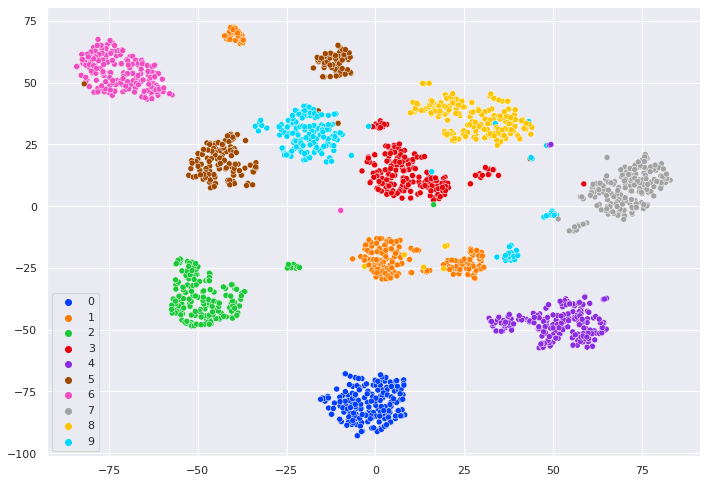

In [44]:
tsne = tSNE()
tsne()

## (a) Brief Summary

Write a brief summary of the code. Annotate key lines.

*Each function/method has been annotated and described in the docstrings in the code above.*

This code performs tSNE, or t-Distributed Stochastic Neighbor Embedding, dimensionality reduction on a dataset of handwritten digits. To perform the transformation, we begin by computing the pairwise euclidean distance between each data point in the feature set. Then, we compute the joint probabilities of these distances using the inputted perplexity parameter. 

The embedding (transformed data) is initialized with randomly selected values from Gaussian distributions with standard deviation `1e^-4`. To perform the tSNE reduction, we flatten the embedding, define our KL divergence objective function, and use it to perform gradient descent on the embedding. The goal in the gradient descent optimization is to minimize the KL divergence. Once the gradient descent has converged, we return the transformed X and plot the resulting 2-dimensional clusters.

## (b) Perplexity Parameter

Vary the perplexity parameter and show results.

### Increase Perplexity

[t-SNE] Iteration 1: error = 3.5334667, gradient norm = 0.0000044
[t-SNE] Iteration 101: error = 0.7897652, gradient norm = 0.0004566
[t-SNE] Iteration 201: error = 0.7086911, gradient norm = 0.0002084
[t-SNE] Iteration 301: error = 0.6860737, gradient norm = 0.0001096
[t-SNE] Iteration 401: error = 0.6765435, gradient norm = 0.0000770
[t-SNE] Iteration 501: error = 0.6708290, gradient norm = 0.0000674
[t-SNE] Iteration 601: error = 0.6671140, gradient norm = 0.0000540
[t-SNE] Iteration 701: error = 0.6647922, gradient norm = 0.0000446
[t-SNE] Iteration 801: error = 0.6629230, gradient norm = 0.0000403
[t-SNE] Iteration 901: error = 0.6616847, gradient norm = 0.0000304


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


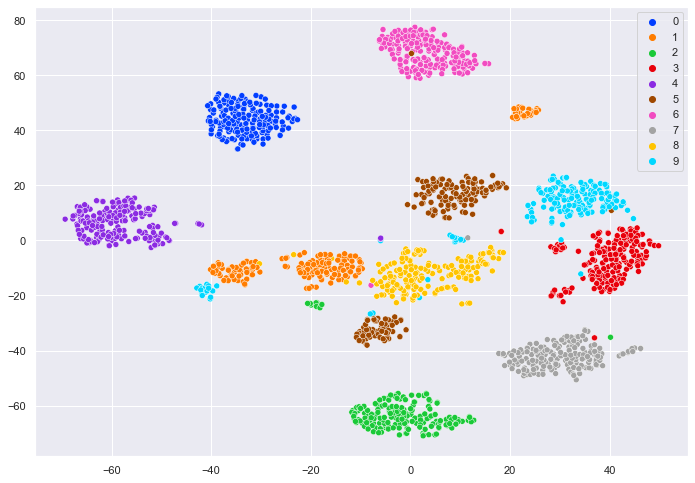

In [ ]:
tsne_1 = tSNE(perplexity=50)
tsne_1()

It seems that when we increase the perplexity, the clusters are closer together than in the original plot. It also seems that there are more pods per cluster spread out in the plot. Since perplexity is related to the number of nearest neighbors used in the algorithm, we could be seeing an instance of overfitting or overparameterization. This is supported by the fact that this version of the transformation got an even lower training error than the original algorithm.

### Decrease Perplexity

[t-SNE] Iteration 1: error = 5.0657909, gradient norm = 0.0000069
[t-SNE] Iteration 101: error = 1.4800154, gradient norm = 0.0009210
[t-SNE] Iteration 201: error = 1.2495760, gradient norm = 0.0004043
[t-SNE] Iteration 301: error = 1.1346257, gradient norm = 0.0004288
[t-SNE] Iteration 401: error = 1.0783688, gradient norm = 0.0002422
[t-SNE] Iteration 501: error = 1.0344100, gradient norm = 0.0001934
[t-SNE] Iteration 601: error = 0.9948240, gradient norm = 0.0001899
[t-SNE] Iteration 701: error = 0.9659291, gradient norm = 0.0001529
[t-SNE] Iteration 801: error = 0.9351062, gradient norm = 0.0002098
[t-SNE] Iteration 901: error = 0.9168651, gradient norm = 0.0001136


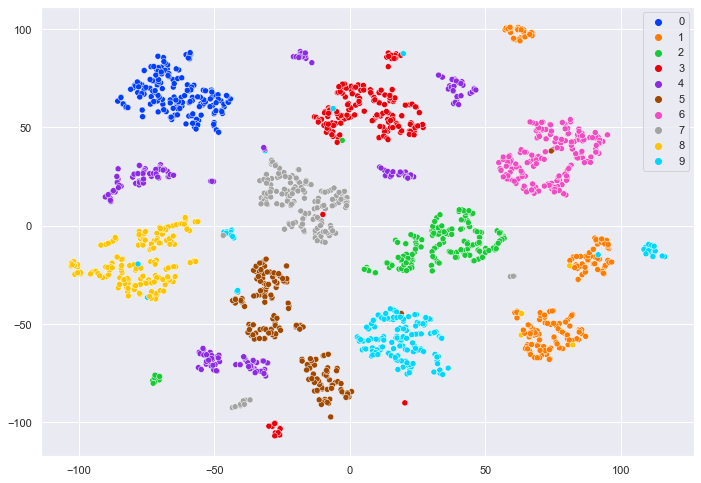

In [ ]:
tsne_2 = tSNE(perplexity=10)
tsne_2()

When we decrease perplexity, the clusters are very obviously less concentrated and cohesive. Each cluster is more spread out than in the original plot, and some clusters don't even have a centralized location but rather are plotted all across the graph. In addition, this version of the transformation had the highest error value. Clearly, we have decreased the perplexity parameter to an undesirable value and we are not able to successfully cluster the data with this version.

# Problem 3 - Spectral Embedding & Clustering

Study and play with the following code for spectral embedding and clustering.

https://towardsdatascience.com/unsupervised-machine-learning-spectral-clustering-algorithm-implemented-from-scratch-in-python-205c87271045

In [39]:
class Spectral:
    """
    Performs spectral clustering from scratch. In spectral clustering, the affinity, and not the absolute location
     (i.e. k-means), determines what points fall under which cluster. Can only be applied to a graph of connected
      nodes.
    """

    def __init__(self, data, hidden_dim=2):
        """
        Constructs necessary parameter for Spectral.
        :param data: array of nodes to build edges from
        """
        self.data = data
        self.hidden_dim = hidden_dim

    def __call__(self):
        """
        Performs entire clustering algorithm, prints several matrices, and draws graph w/ corresponding clusters.
        :return: nothing
        """
        # construct a similarity graph
        G = self.construct_graph()
        # determine the Adjacency matrix W, Degree matrix D and the Laplacian matrix L
        L = self.get_matrices(G)
        # compute the eigenvectors of the matrix L
        e, v = self.compute_eigens(L)
        # using the second smallest eigenvector as input, train a k-means model and use it to classify the data
        labels = self.train_kmeans(e, v)
        # get color list
        colors = self.make_colors(labels)
        # draw
        self.draw_graph(G, node_color=colors)

    @staticmethod
    def make_colors(labels):
        """
        Utility function to map cluster labels to colors for plot.
        :param labels: label output from kmeans
        :return: mapped color list
        """
        colors = []
        for label in labels:
            if label == 0:
                colors.append('r')
            elif label == 1:
                colors.append('b')
            elif label == 2:
                colors.append('g')
        return colors

    @staticmethod
    def draw_graph(G, node_color='r'):
        """
        Utility function to draw connected node graph.
        :param node_color: list or single string for node colors
        :param G: graph to draw
        :return: nothing
        """
        pos = nx.spring_layout(G)
        nx.draw_networkx_nodes(G, pos, node_color=node_color)
        nx.draw_networkx_labels(G, pos)
        nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)

    def construct_graph(self):
        """
        Generates a graph and adds edges based on initialized data object.
        :return: graph
        """
        G = nx.Graph()
        G.add_edges_from(self.data)
        return G

    @staticmethod
    def get_matrices(G):
        """
        Computes adjacency matrix, degree matrix, and Laplacian matrix.
        :param G: graph
        :return: laplacian matrix
        """
        # adjacency matrix
        W = nx.adjacency_matrix(G)
        print('adjacency matrix:')
        print(W.todense())
        # construct the degree matrix
        D = np.diag(np.sum(np.array(W.todense()), axis=1))
        print('degree matrix:')
        print(D)
        # laplacian matrix, subtract adjacency matrix from degree matrix
        L = D - W
        print('laplacian matrix:')
        print(L)
        return L

    @staticmethod
    def compute_eigens(L):
        """
        Computes eigenvalues and eigenvectors of inputted Laplacian matrix.
        :param L: laplacian matrix
        :return: eigenvalues, eigenvectors
        """
        # compute the eigenvalues and eigenvectors of the laplacian
        e, v = np.linalg.eig(L)
        return e, v

    @staticmethod
    def train_kmeans(e, v):
        """
        Trains a k-means model using the second smallest eigenvector as input and uses it to classify the data.
        :param e: eigenvalues
        :param v: eigenvectors
        :return: cluster labels
        """
        # using the second smallest eigenvector, use K-means to classify the nodes based
        # off their corresponding values in the eigenvector
        i = np.where(e < 0.5)[0]
        U = np.array(v[:, i[1]])
        km = KMeans(init='k-means++', n_clusters=3)
        km.fit(U)
        print(km.labels_)
        return km.labels_


In [34]:
data = np.array([
    [1, 2],
    [1, 3],
    [1, 4],
    [2, 3],
    [3, 4],
    [4, 5],
    [1, 5],
    [6, 7],
    [7, 8],
    [6, 8],
    [6, 9],
    [9, 6],
    [7, 10],
    [7, 2]
])

adjacency matrix:
[[0 1 1 1 1 0 0 0 0 0]
 [1 0 1 0 0 0 1 0 0 0]
 [1 1 0 1 0 0 0 0 0 0]
 [1 0 1 0 1 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 0]
 [0 1 0 0 0 1 0 1 0 1]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]
degree matrix:
[[4 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]]
laplacian matrix:
[[ 4 -1 -1 -1 -1  0  0  0  0  0]
 [-1  3 -1  0  0  0 -1  0  0  0]
 [-1 -1  3 -1  0  0  0  0  0  0]
 [-1  0 -1  3 -1  0  0  0  0  0]
 [-1  0  0 -1  2  0  0  0  0  0]
 [ 0  0  0  0  0  3 -1 -1 -1  0]
 [ 0 -1  0  0  0 -1  4 -1  0 -1]
 [ 0  0  0  0  0 -1 -1  2  0  0]
 [ 0  0  0  0  0 -1  0  0  1  0]
 [ 0  0  0  0  0  0 -1  0  0  1]]
[1 2 1 1 1 0 0 0 0 0]


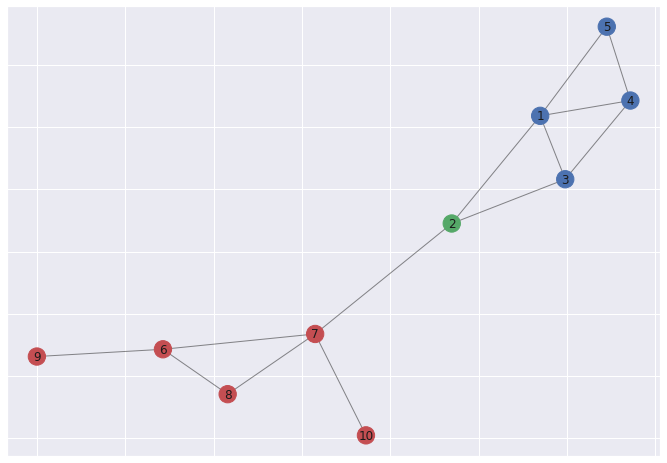

In [37]:
spectral = Spectral(data=data)
spectral()

## (a) Brief Summary

Write a brief summary of the code. Annotate key lines.

*Each function/method has been annotated and described in the docstrings in the code above.*

This code performs spectral clustering from scratch. Spectral clustering differs from K-Means clustering in that it groups observation based on affinity rather than, say, euclidean distance. Spectral clustering can only be applied to a graph of connected nodes. The algorithm consists of computing the adjacency, degree, and Laplacian matrix of a graph, obtaining the second smallest eigenvalue/eigenvector of the Laplacian, and performing K-Means on that eigenvector to classify the data.

In the code, this exact algorithm is implemented. It is initialized only with an array of data points, and from that array a graph is generated. That graph is used to compute the several aforementioned matrices from which the second smallest eigenvector is obtained. Finally, K-Means is performed on this eigenvector and used to output cluster labels with which the graph is plotted accordingly.

## (b) Cluster Plot

Let the dimension of hidden vector be 2, plot the data in the latent space, and see if they form well separated clusters.

Whenever we graph points or think of points in latent space, we can imagine them as coordinates in space in which points that are “similar” are closer together on the graph. Therefore, to plot the data in the latent space, we plot the nodes on the graph along with their cluster color.

adjacency matrix:
[[0 1 1 1 1 0 0 0 0 0]
 [1 0 1 0 0 0 1 0 0 0]
 [1 1 0 1 0 0 0 0 0 0]
 [1 0 1 0 1 0 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 0]
 [0 1 0 0 0 1 0 1 0 1]
 [0 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]
degree matrix:
[[4 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1]]
laplacian matrix:
[[ 4 -1 -1 -1 -1  0  0  0  0  0]
 [-1  3 -1  0  0  0 -1  0  0  0]
 [-1 -1  3 -1  0  0  0  0  0  0]
 [-1  0 -1  3 -1  0  0  0  0  0]
 [-1  0  0 -1  2  0  0  0  0  0]
 [ 0  0  0  0  0  3 -1 -1 -1  0]
 [ 0 -1  0  0  0 -1  4 -1  0 -1]
 [ 0  0  0  0  0 -1 -1  2  0  0]
 [ 0  0  0  0  0 -1  0  0  1  0]
 [ 0  0  0  0  0  0 -1  0  0  1]]
[0 2 0 0 0 1 1 1 1 1]


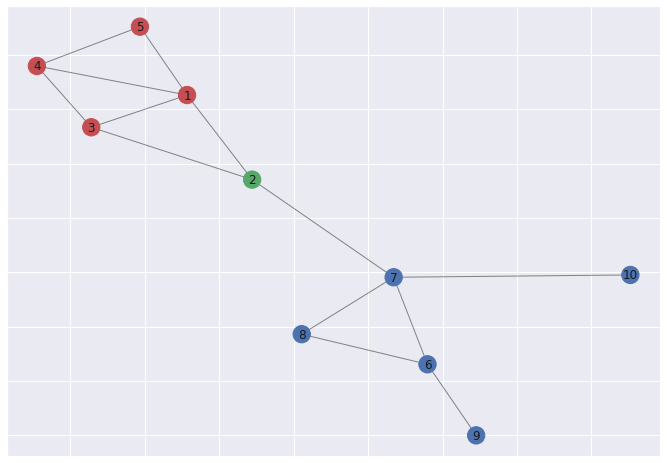

In [41]:
spectral_b = Spectral(data=data, hidden_dim=2)
spectral_b()

We can see that the algorithm has formed well-separated clusters.